In [1]:
# ! pip install polars networkx matplotlib scikit-learn

## Load & Prepare Data

In [2]:
import polars as pl


DATA_PATH = "../data/RAW_recipes.csv"

# Load only the necessary columns
recipes = pl.scan_csv(DATA_PATH)

recipes = recipes.with_columns(  # Convert string list to actual list
    pl.col("ingredients")
    .str.strip_suffix("]")
    .str.strip_prefix("[")
    .str.replace_all("'", "")
    .str.split(',')
    .list.eval(pl.element().str.strip_chars())
    # .alias("ingredients")
)

# df.collect()
# df.select("ingredients").collect().item(0, 0)

In [3]:
# limit recipes beforehand
RECIPE_LIMIT = 1000

recipes = recipes.head(RECIPE_LIMIT)

In [4]:
# get all unique ingrediences for inverted index generation
unique_ingr = recipes.select(
    pl.col("ingredients").list.explode().alias("ingredient")
).unique()

# unique_ingr.collect()

## Graph Processing

### Nodes

In [5]:
import networkx as nx


# Create an empty graph
G = nx.Graph()

# Add nodes (recipes)
df_selection = recipes.select(['id', 'name']).collect()
for idx, name in df_selection.iter_rows():
    G.add_node(idx, name=name)

### Edgessss

Weight calculation with inverted index


In [6]:
# Building graph by shared ingredients by recipes

ingredients_with_recipes = unique_ingr.join(
    recipes.explode("ingredients"),
    how="left",
    left_on="ingredient",
    right_on="ingredients"
)

ingredients_with_recipes = ingredients_with_recipes.group_by("ingredient").agg(
    pl.col("id").alias("recipe_ids")
)

ingredients_with_recipes.collect()

ingredient,recipe_ids
str,list[i64]
"""chow mein noodles""",[142984]
"""escarole""",[23850]
"""tomato juice""","[44061, 196548]"
"""1% low-fat milk""","[383339, 385464, 482111]"
"""honey""","[137739, 67888, … 282812]"
…,…
"""brown mustard""",[428056]
"""taco sauce""","[59952, 349293]"
"""reduced sodium soy sauce""",[107229]


optimize dataset

- cut top 5% of ingrediences by commenness (can be changed)
- only consider ingrediences used by at least 2 recepies (can also be changed)

In [7]:
# analyze if there are too common ingredients

LESS_COMMON_INGR_PRCT =  0.95
MIN_OCC_SHRD_INGR = 2

ingredients_with_recipes = ingredients_with_recipes.with_columns(
    pl.col("recipe_ids").list.len().alias("occurrences")
).sort("occurrences", descending=True)

# ingredients_with_recipes.collect()

# find shared ingredients (> 1 recipe per ingredient)
shared_ingredients = ingredients_with_recipes.filter(
    pl.col("occurrences") >= MIN_OCC_SHRD_INGR
)

shared_ingredients.collect()

# cut very common ingredients
shared_ingredients = shared_ingredients.bottom_k(int(shared_ingredients.count().collect().item(0, 0) * LESS_COMMON_INGR_PRCT), by = "occurrences")

shared_ingredients.collect()

ingredient,recipe_ids,occurrences
str,list[i64],u32
"""mixed spice""","[137739, 423369]",2
"""red chile""","[25274, 303460]",2
"""light olive oil""","[108804, 22711]",2
"""self rising flour""","[168420, 33246]",2
"""yellow squash""","[167554, 384510]",2
…,…,…
"""carrot""","[44123, 52804, … 364761]",30
"""garlic clove""","[176110, 225707, … 364157]",31
"""raisins""","[93958, 26995, … 109793]",32


prepare edges weights

In [8]:
from itertools import combinations


def recipe_combinations(recipes):
    # Return sorted recipe pairs as tuples
    return [tuple(sorted(pair)) for pair in combinations(recipes, 2)] if len(recipes) >= 2 else []

# Create a new column with all recipe pairs for each ingredient
shared_ingredients = shared_ingredients.with_columns(
    pl.col("recipe_ids").map_elements(
        recipe_combinations,
        return_dtype=pl.List(pl.Struct([pl.Field("r1", pl.Int64), pl.Field("r2", pl.Int64)]))
    ).alias("pairs")
)

# Explode so each row = one recipe pair
pairs_df = shared_ingredients.explode("pairs").select("pairs")

# Convert struct to separate columns for group_by
edges = pairs_df.with_columns([
    pl.col("pairs").struct.field("r1"),
    pl.col("pairs").struct.field("r2"),
]).select(["r1", "r2"])

# Count how often each recipe pair appears (i.e. how many ingredients they share)
edge_weights = (
    edges.group_by(["r1", "r2"])
    .count()
    .rename({"count": "weight"})
    .sort("weight", descending=True)
)

edge_weights.collect()


C:\Users\debrouwe\AppData\Local\Temp\ipykernel_4688\2479875405.py:28: DeprecationWarning: `LazyGroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


r1,r2,weight
i64,i64,u32
93958,93959,9
50614,459089,6
44123,154007,5
336744,487173,4
138005,165856,4
…,…,…
44123,359203,1
83542,109793,1
358003,359972,1


build edges

In [9]:
# build edges

G = nx.Graph()

edge_df = edge_weights.collect()
for row in edge_weights.collect().iter_rows():
    G.add_edge(row[0], row[1], weight=row[2])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 982 nodes and 19303 edges.


## Analyze idea

1. center

In [10]:
# Get connected components (as sets of nodes)
components = list(nx.connected_components(G))

# Optional: sort by size, descending
components = sorted(components, key=len, reverse=True)

# Work with the largest connected component
largest = components[0]
G_largest = G.subgraph(largest)

# Now safely compute center
center_nodes = nx.center(G_largest)
print("Center node(s) of the largest connected component:", center_nodes)

Center node(s) of the largest connected component: [93958, 93959, 50614, 459089, 44123, 154007, 336744, 137434, 303457, 70099, 107229, 53402, 255985, 190411, 138005, 165856, 436082, 116449, 306590, 395202, 84610, 205331, 495344, 325714, 127048, 230565, 250883, 39893, 59515, 185799, 215290, 57203, 212188, 39226, 523359, 489707, 392150, 347252, 196319, 399709, 251528, 302399, 17490, 102832, 64045, 376660, 60454, 112984, 422277, 291073, 104243, 472955, 32169, 200148, 416980, 49737, 185088, 513531, 29214, 129227, 258868, 243409, 218671, 419921, 161370, 411859, 38276, 95534, 289559, 32204, 147286, 39172, 298908, 497150, 51506, 276594, 311991, 80411, 248962, 83062, 214193, 303460, 78655, 239306, 426696, 190108, 367823, 5060, 219681, 368257, 531148, 196006, 531143, 392181, 467076, 74284, 319381, 326839, 441744, 105069, 9999, 143750, 17265, 167554, 503475, 207897, 300339, 172373, 140610, 216030, 187843, 391335, 207743, 213681, 130002, 236184, 81185, 632, 135933, 133328, 435816, 255916, 84797, 

2. clusters

In [11]:
from networkx.algorithms.community import greedy_modularity_communities


clusters = list(greedy_modularity_communities(G))
print(f"Detected {len(clusters)} clusters.")


Detected 6 clusters.


visualize graph (2D)

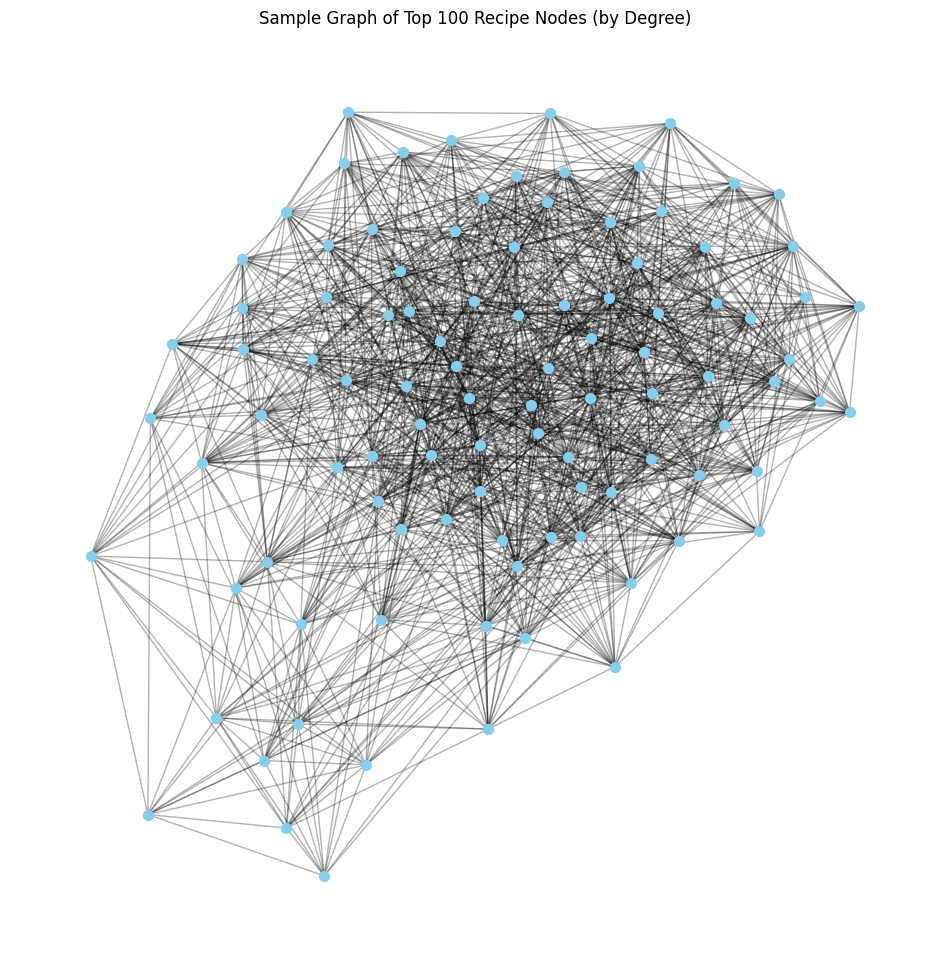

In [12]:
import matplotlib.pyplot as plt


# Take a subgraph of the top 100 nodes (based on degree)
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:100]
H = G.subgraph([n for n, _ in top_nodes])
# Improve layout quality and reduce overlap (slow but nice)
pos = nx.spring_layout(H, seed=42, k=0.15)  # You can tweak `k` for spacing

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(H, pos, node_size=50, node_color="skyblue")
nx.draw_networkx_edges(H, pos, alpha=0.3)
plt.title("Sample Graph of Top 100 Recipe Nodes (by Degree)")
plt.axis("off")
plt.show()